<a href="https://colab.research.google.com/github/AbdullahHemada/Vision_project/blob/main/final_ucf_101_final_trail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time

import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau ,ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D ,Bidirectional
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# Hyperparameter

In [ ]:
# # Parameters
IMG_SIZE = (112, 112)
SEQUENCE_LENGTH = 20
BATCH_SIZE = 8
EPOCHS = 100
NUM_CLASSES = 5
Selected_classes = ['ApplyEyeMakeup', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching']

# Import Label File

In [ ]:
# Load label data
label_data = pd.read_csv("/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
print(label_data.head())


# Total Number of video folders for classification
print(len(label_data))
print(label_data['index'],label_data['labels'])

   index          labels
0      1  ApplyEyeMakeup
1      2   ApplyLipstick
2      3         Archery
3      4    BabyCrawling
4      5     BalanceBeam
101
0        1
1        2
2        3
3        4
4        5
      ... 
96      97
97      98
98      99
99     100
100    101
Name: index, Length: 101, dtype: int64 0         ApplyEyeMakeup
1          ApplyLipstick
2                Archery
3           BabyCrawling
4            BalanceBeam
             ...        
96     VolleyballSpiking
97        WalkingWithDog
98           WallPushups
99        WritingOnBoard
100                 YoYo
Name: labels, Length: 101, dtype: object


In [ ]:
# Filter label_data to only selected classes
label_data_filtered = label_data[label_data['labels'].isin(Selected_classes)]

# Create new class → index
class_to_index = {cls: i for i, cls in enumerate(Selected_classes)}

print("Filtered classes:", class_to_index)

Filtered classes: {'ApplyEyeMakeup': 0, 'Archery': 1, 'BabyCrawling': 2, 'BalanceBeam': 3, 'BandMarching': 4}


# import and read train01 and test01

1) Load train list & keep only selected classes

In [ ]:
#read train01.txt file
UCF101_path='/kaggle/input/ucf101/UCF101/UCF-101'
train01_path='/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt'
test01_path='/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/testlist01.txt'


# Load filtered train lists
def load_train_list_filtered(train01_path, selected_classes):
    videos = []
    labels = []

    with open(train01_path, 'r') as file:
        for line in file:
            video_file, label_num = line.strip().split()
            class_name = video_file.split('/')[0]

            # only keep selected classes
            if class_name in selected_classes:
                videos.append(video_file)
                labels.append(selected_classes.index(class_name))

    return videos, labels


# Load filtered  test lists
def load_test_list_filtered(test01_path, selected_classes):
    videos = []

    with open(test01_path, 'r') as file:
        for line in file:
            video_file = line.strip()
            class_name = video_file.split('/')[0]

            if class_name in selected_classes:
                videos.append(video_file)

    return videos


LOAD full path  FOR TRAINING AND TESTING

In [ ]:
# Load filtered train and test lists
train_videos, train_labels = load_train_list_filtered(train01_path, Selected_classes)
test_videos = load_test_list_filtered(test01_path, Selected_classes)



train_full_path=[]
for video in train_videos:
    train_full_path.append(os.path.join(UCF101_path, video))


test_full_path=[]
for video in test_videos:
    test_full_path.append(os.path.join(UCF101_path, video))

# print(train_full_path)
# print(test_full_path)


# Data Preperation

**get video fram size**

In [ ]:
# Print video frame sizes ONLY for selected classes
print("Reading video sizes for selected classes...\n")

for cls in Selected_classes:
    class_folder = os.path.join(UCF101_path, cls)
    for file in os.listdir(class_folder):
        if file.endswith(".avi"):
            video_path = os.path.join(class_folder, file)
            cap = cv2.VideoCapture(video_path)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            print(f"{cls}/{file}: {w}x{h}")

            cap.release()


Reading video sizes for selected classes...

ApplyEyeMakeup/v_ApplyEyeMakeup_g19_c01.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c05.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g13_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c01.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g12_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g21_c05.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c03.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g20_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c07.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g22_c01.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g05_c07.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g24_c03.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g20_c04.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c04.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g23_c05.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi: 320x240
ApplyEyeMakeup/v_ApplyEyeMakeup_g05_c02.avi: 320x240
A

# ploting each category and its number


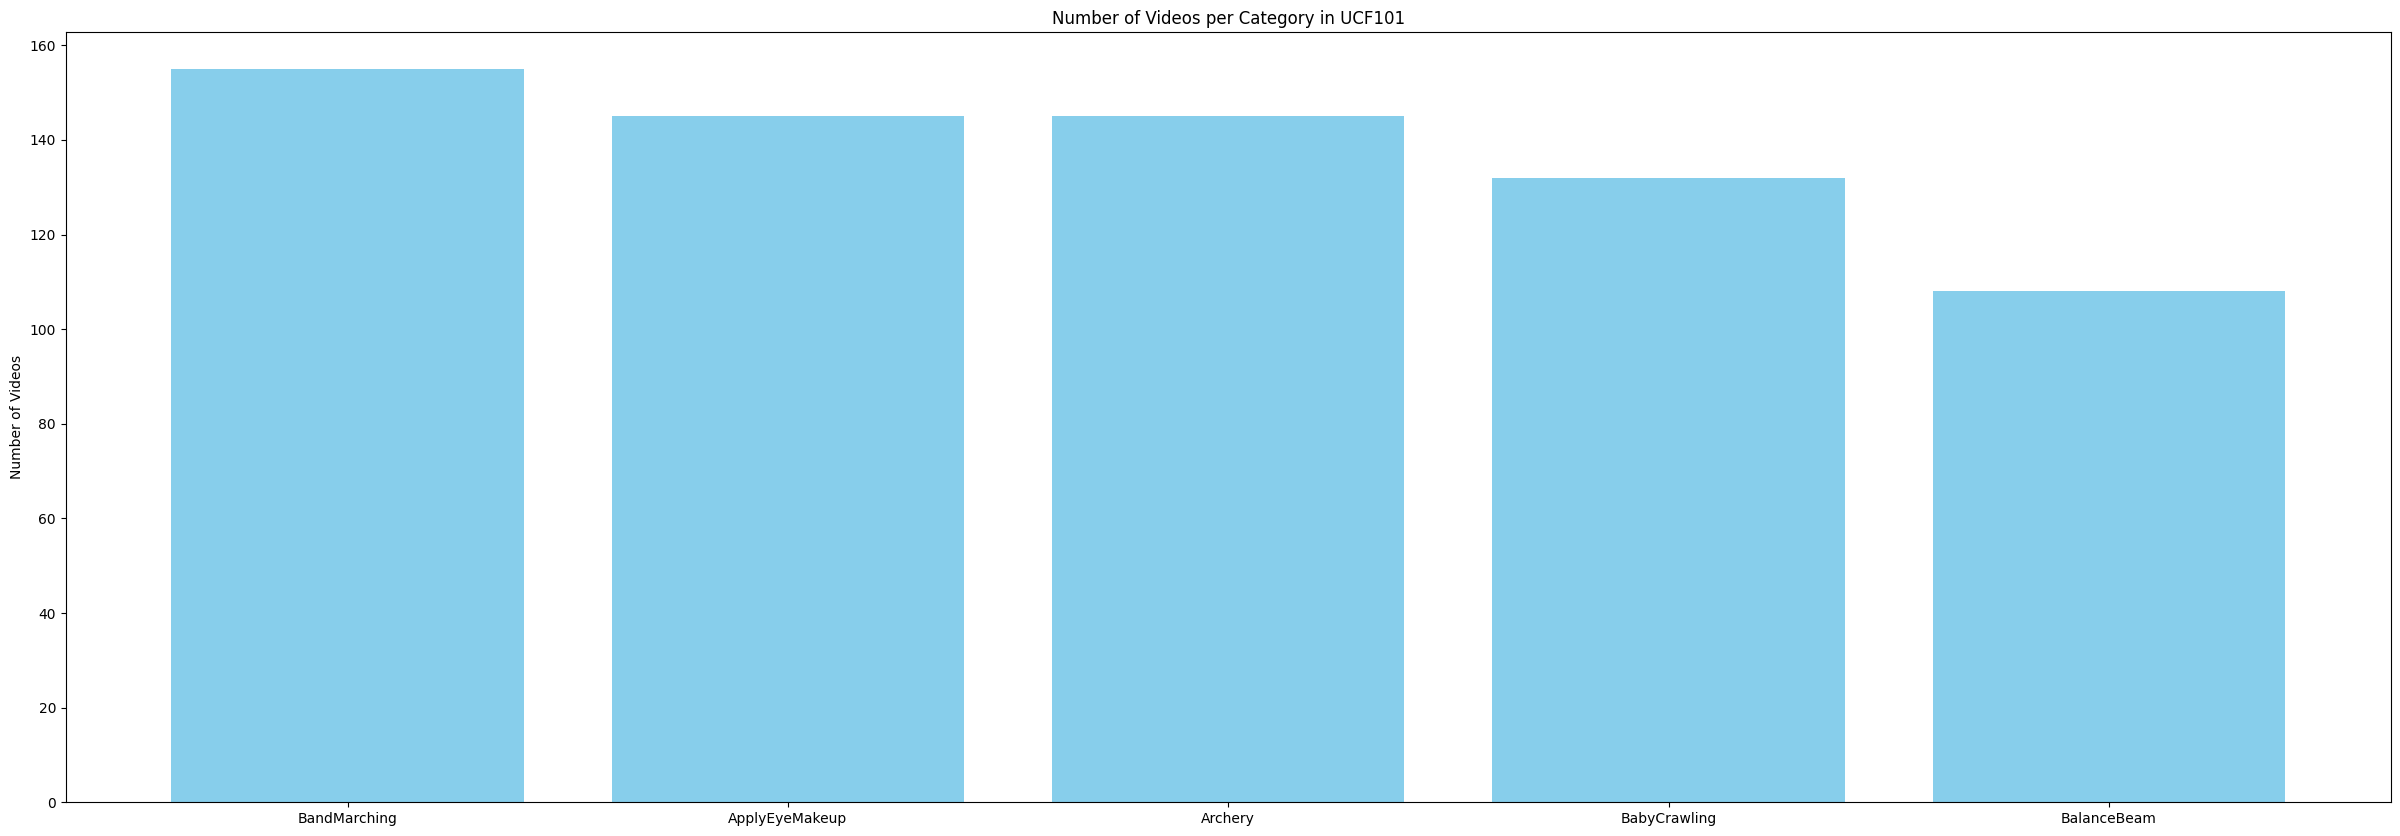

In [ ]:
# ploting each category and its number


# Count videos in each category
video_counts = {}
for category in Selected_classes:
    category_path = os.path.join(UCF101_path, category)
    videos = [f for f in os.listdir(category_path) if f.endswith(".avi")]
    video_counts[category] = len(videos)

# Sort categories by number of videos (descending)
sorted_counts = dict(sorted(video_counts.items(), key=lambda item: item[1], reverse=True))

# Plot bar chart
plt.figure(figsize=(30, 10))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Category in UCF101")
plt.show()


# Function for Feature Extraction


In [ ]:
def extract_frames(video_path, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):
    width, height = img_size

    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list



# Augmentation Function

In [ ]:
# def augment_frames(frames):
#     aug_frames = []

#     for frame in frames:

#         f = frame.copy()

#         # Random horizontal flip
#         if random.random() < 0.5:
#             f = cv2.flip(f, 1)

#         # Random brightness change
#         if random.random() < 0.3:
#             factor = 0.8 + random.random() * 0.4
#             f = np.clip(f * factor, 0, 1)

#         # Color jitter
#         if random.random() < 0.3:
#             shift = random.uniform(-0.1, 0.1)
#             f = np.clip(f + shift, 0, 1)

#         # Random noise
#         if random.random() < 0.2:
#             noise = np.random.normal(0, 0.03, f.shape)
#             f = np.clip(f + noise, 0, 1)

#         aug_frames.append(f)

#     return np.array(aug_frames)


## Load selected train data from train01.txt

In [ ]:
def load_train_videos(video_paths, labels):
    X = []
    y = []

    for i, video_path in enumerate(tqdm(video_paths, desc="Loading TRAIN videos")):
        frames = extract_frames(video_path)          # extract
        # frames = augment_frames(frames)              # augment
        X.append(frames)
        y.append(labels[i])

    return np.array(X), np.array(y)


# Example usage
x_all, y_all = load_train_videos(train_full_path, train_labels)

# Train-validation split
x_train_manual, x_val_manual, y_train_manual, y_val_manual = train_test_split(
    x_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)


Loading TRAIN videos: 100%|██████████| 491/491 [02:59<00:00,  2.74it/s]


In [ ]:
def load_test_videos(video_paths, class_to_index, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):

    X_test = []
    y_test = []

    for video_path in tqdm(video_paths, desc="Loading test videos"):
        class_name = os.path.basename(os.path.dirname(video_path))
        if class_name not in class_to_index:
            continue  # skip classes not selected
        label = class_to_index[class_name]
        frames = extract_frames(video_path)
        X_test.append(frames)
        y_test.append(label)

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_test, y_test

# Example usage
x_test, y_test = load_test_videos(test_full_path, class_to_index)


Loading test videos: 100%|██████████| 194/194 [00:51<00:00,  3.79it/s]


## The Proposal model: MobilnetV2 + LSTM

In [ ]:
# Build model
def build_model_mobilenet_lstm():
    inputs = Input(shape=(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], 3))

    # Preprocessing
    x = TimeDistributed(Lambda(preprocess_input))(inputs)

    # CNN backbone
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=( IMG_SIZE[0], IMG_SIZE[1],3)
    )


    base_model.trainable = False  # freeze for stability

    x = TimeDistributed(base_model)(x)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Temporal modeling
    x = LSTM(256, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Classification
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
# Callbacks
# early_stop = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-4)
callbacks = [
    ModelCheckpoint("best_ucf_resnet50.h5", save_best_only=True, monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]


In [ ]:
# define dictionaries BEFORE training
histories = {}
times = {}

**➤ 1. Train with Adam**

In [ ]:
model_adam = build_model_mobilenet_lstm()

model_adam.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(1e-3),
    metrics=["accuracy"]
)


start = time.time()

history = model_adam.fit(
    x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
end = time.time()

# Save results
histories["Adam"] = history
times["Adam"] = end - start

I0000 00:00:1766080546.598738      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


I0000 00:00:1766080666.072149    5605 cuda_dnn.cc:529] Loaded cuDNN version 90300


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4568 - loss: 1.3035

49/49 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.4590 - loss: 1.2986 - val_accuracy: 0.7374 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6468 - loss: 0.8132

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step - accuracy: 0.6479 - loss: 0.8119 - val_accuracy: 0.7677 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8013 - loss: 0.5186

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.8010 - loss: 0.5197 - val_accuracy: 0.7980 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8529 - loss: 0.4510

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.8526 - loss: 0.4511 - val_accuracy: 0.8384 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9053 - loss: 0.3648

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.9049 - loss: 0.3651 - val_accuracy: 0.8687 - val_loss: 0.4419 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.8927 - loss: 0.3394 - val_accuracy: 0.8485 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.9201 - loss: 0.2758 - val_accuracy: 0.8485 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.9320 - loss: 0.2226 - val_accuracy: 0.8485 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.8753 - loss: 0.3334 - val_accuracy: 0.8485 - val_loss: 0.4258 - learning_rate: 0.0010
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.9250 - loss: 0.2156 - val_accuracy: 0.8586 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.9354 - loss: 0.239

49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.9692 - loss: 0.1336 - val_accuracy: 0.8889 - val_loss: 0.3830 - learning_rate: 0.0010
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.9510 - loss: 0.1561 - val_accuracy: 0.8182 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.9618 - loss: 0.1364 - val_accuracy: 0.8788 - val_loss: 0.3969 - learning_rate: 0.0010
Epoch 16/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.9688 - loss: 0.0921 - val_accuracy: 0.8485 - val_loss: 0.4105 - learning_rate: 0.0010
Epoch 17/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.9721 - loss: 0.0879 - val_accuracy: 0.8485 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 18/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.9699 - loss: 0.1161 - val_accuracy: 0.8889 - val_loss: 0.3395 - learning_rate: 0.0010
Epoch 19/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.9849 - loss: 0

In [ ]:
y_pred = np.argmax(model_adam.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step 
Test Accuracy: 0.7525773195876289


**➤ 2. Train with SGD**

In [ ]:
model_sgd = build_model_mobilenet_lstm()

model_sgd.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)
start = time.time()
history_sgd = model_sgd.fit(
  x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

end = time.time()

# Save results
histories["SGD"] = history
times["SGD"] = end - start

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.2539 - loss: 1.6288 - val_accuracy: 0.4545 - val_loss: 1.3918 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.3909 - loss: 1.4449 - val_accuracy: 0.5859 - val_loss: 1.2181 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.5151 - loss: 1.2095 - val_accuracy: 0.6364 - val_loss: 1.1152 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.6131 - loss: 1.1029 - val_accuracy: 0.6869 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.6083 - loss: 1.0456 - val_accuracy: 0.7071 - val_loss: 0.9464 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.6555 - loss: 1.0138 - val_accuracy: 0.7273 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.6393 - los

**➤ 3. Train with Adagrad**


In [ ]:
model_ada = build_model_mobilenet_lstm()

model_ada.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adagrad(learning_rate=0.001),
    metrics=['accuracy']
)
start = time.time()


history_ada = model_ada.fit(
       x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
end = time.time()

histories["Adagrad"] = history_ada
times["Adagrad"] = end - start

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.2917 - loss: 1.6190 - val_accuracy: 0.6667 - val_loss: 1.1299 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.4969 - loss: 1.1882 - val_accuracy: 0.6667 - val_loss: 0.9468 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.6542 - loss: 0.9752 - val_accuracy: 0.6869 - val_loss: 0.8336 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.6714 - loss: 0.9186 - val_accuracy: 0.7374 - val_loss: 0.8011 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.6576 - loss: 0.9192 - val_accuracy: 0.7172 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.7390 - loss: 0.8480 - val_accuracy: 0.7879 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.7315 - los

In [ ]:
for opt, t in times.items():
    print(f"{opt}: {t:.2f} seconds")


Adam: 564.63 seconds
SGD: 1576.03 seconds
Adagrad: 1070.52 seconds


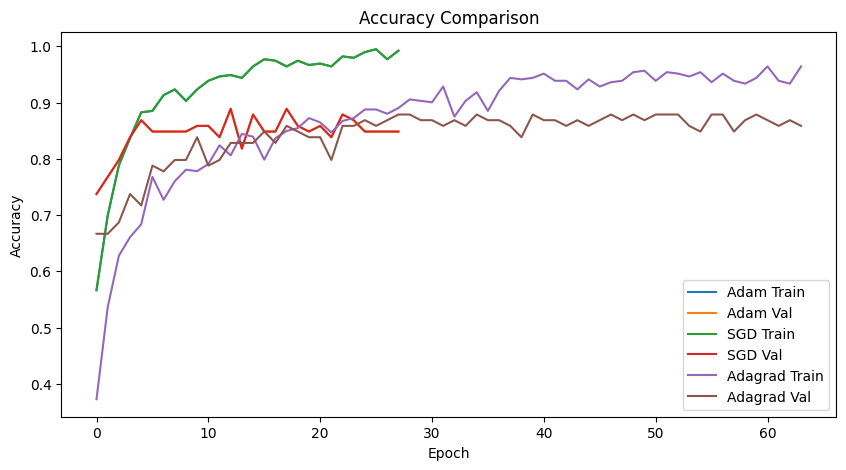

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')

plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**Plot accuracy curves:**

**Plot loss curves:**

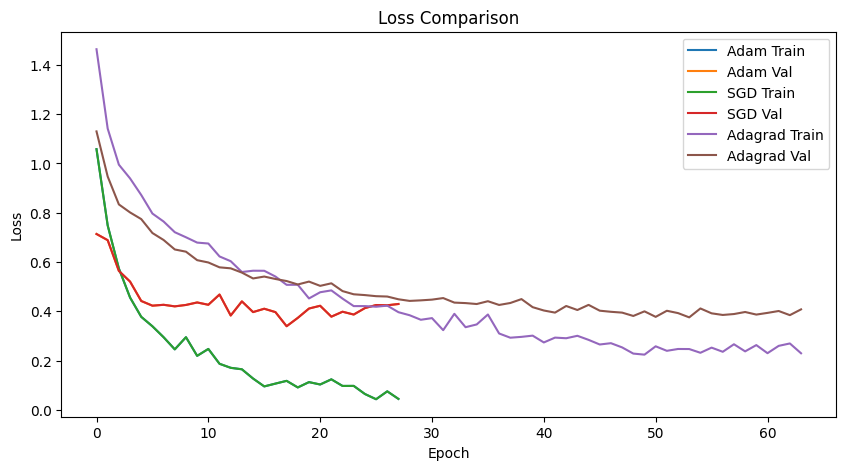

In [ ]:
plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Val')

plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# One-hot encode test labels
# y_test_cat = to_categorical(y_test, NUM_CLASSES)

print("Adam Test Accuracy:", model_adam.evaluate(x_test, y_test))
print("SGD Test Accuracy:", model_sgd.evaluate(x_test, y_test))
print("Adagrad Test Accuracy:", model_ada.evaluate(x_test, y_test))



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.7225 - loss: 0.7997
Adam Test Accuracy: [0.7767680883407593, 0.7525773048400879]
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.7263 - loss: 0.8227
SGD Test Accuracy: [0.8037301301956177, 0.7216494679450989]
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.7283 - loss: 0.8068
Adagrad Test Accuracy: [0.7891313433647156, 0.7216494679450989]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

test_accuracies = {}
test_predictions = {}

# -----------------------
# 🔵 1) ADAM
# -----------------------
y_pred_adam = model_adam.predict(x_test)
pred_class_adam = np.argmax(y_pred_adam, axis=1)

acc_adam = accuracy_score(y_test, pred_class_adam)
test_accuracies["Adam"] = acc_adam
test_predictions["Adam"] = pred_class_adam

print("Adam Test Accuracy:", acc_adam)


# -----------------------
# 🔴 2) SGD
# -----------------------
y_pred_sgd = model_sgd.predict(x_test)
pred_class_sgd = np.argmax(y_pred_sgd, axis=1)

acc_sgd = accuracy_score(y_test, pred_class_sgd)
test_accuracies["SGD"] = acc_sgd
test_predictions["SGD"] = pred_class_sgd

print("SGD Test Accuracy:", acc_sgd)


# -----------------------
# 🟢 3) ADAGRAD
# -----------------------
y_pred_ada = model_ada.predict(x_test)
pred_class_ada = np.argmax(y_pred_ada, axis=1)

acc_ada = accuracy_score(y_test, pred_class_ada)
test_accuracies["Adagrad"] = acc_ada
test_predictions["Adagrad"] = pred_class_ada

print("Adagrad Test Accuracy:", acc_ada)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step
Adam Test Accuracy: 0.7525773195876289
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step 
SGD Test Accuracy: 0.7216494845360825
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step 
Adagrad Test Accuracy: 0.7216494845360825


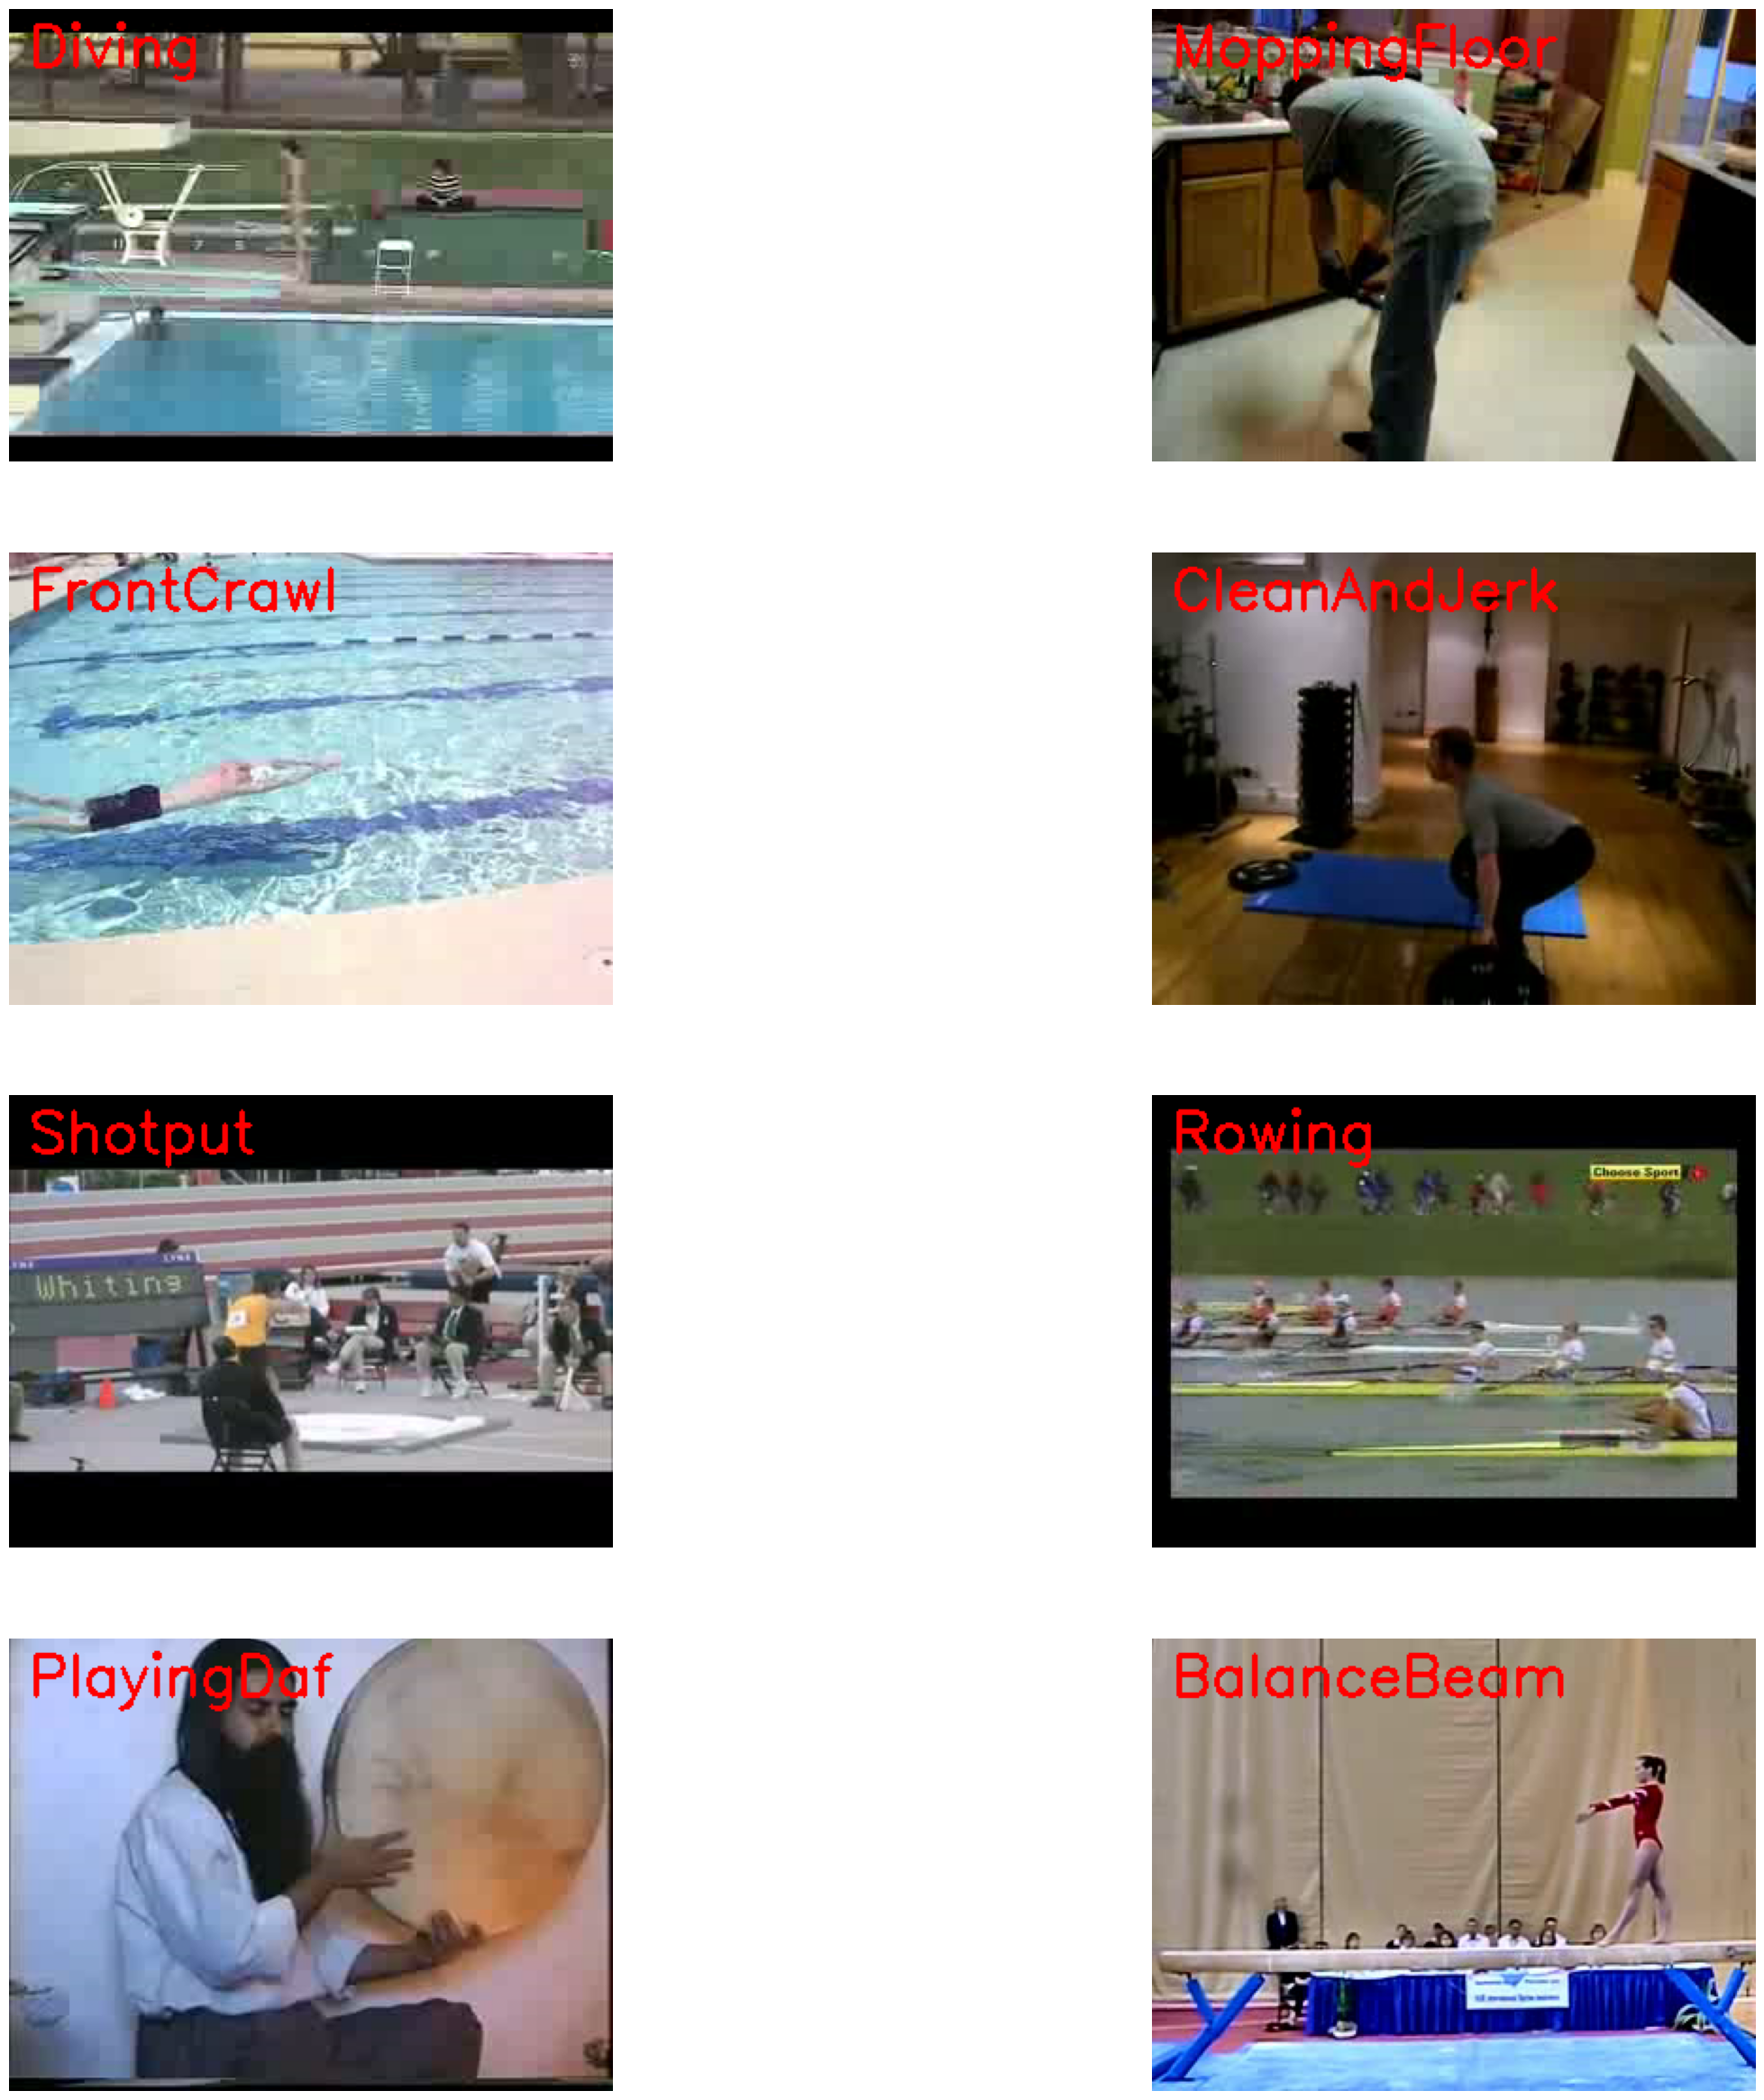

In [ ]:
import random
import os
import cv2

plt.figure(figsize=(30, 30))

all_classes_names = label_data.labels.values

random_classes = random.sample(list(all_classes_names), 8)

for i, class_name in enumerate(random_classes, 1):

    video_files = os.listdir(f'/kaggle/input/ucf101/UCF101/UCF-101/{class_name}')
    selected_video = random.choice(video_files)

    video_reader = cv2.VideoCapture(
        f'/kaggle/input/ucf101/UCF101/UCF-101/{class_name}/{selected_video}'
    )

    _, frame = video_reader.read()
    video_reader.release()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(frame, class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

    plt.subplot(4, 2, i)
    plt.imshow(frame)
    plt.axis("off")



====== OPTIMIZER COMPARISON TABLE ======
  Optimizer  Train Time (s)  Test Accuracy
0      Adam      564.629887       0.752577
1       SGD     1576.030525       0.721649
2   Adagrad     1070.517040       0.721649


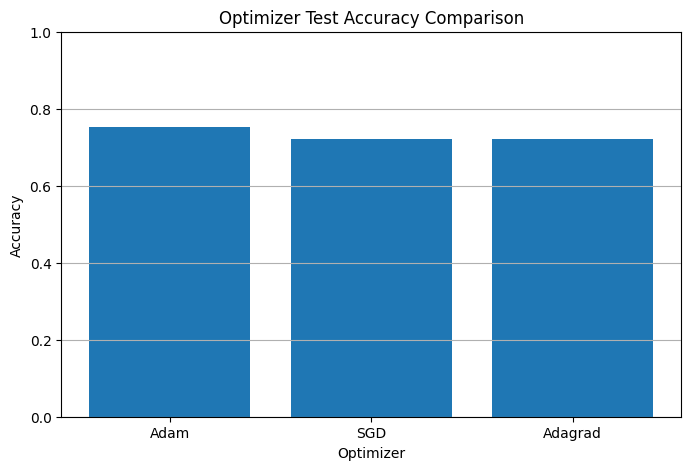

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step


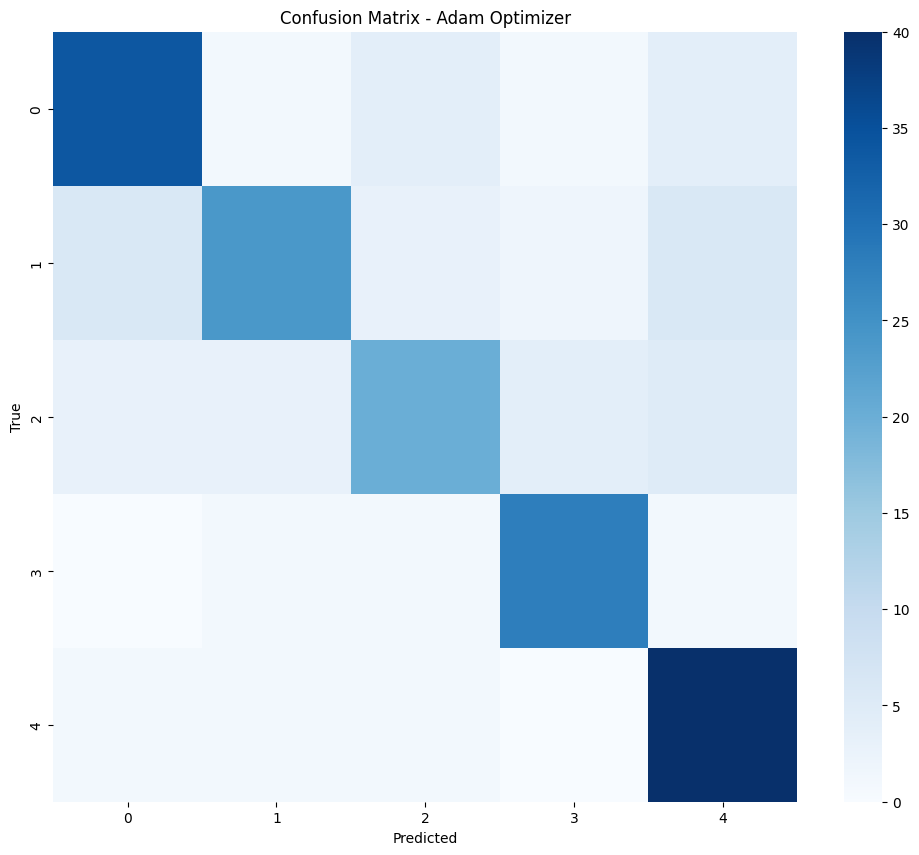

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step


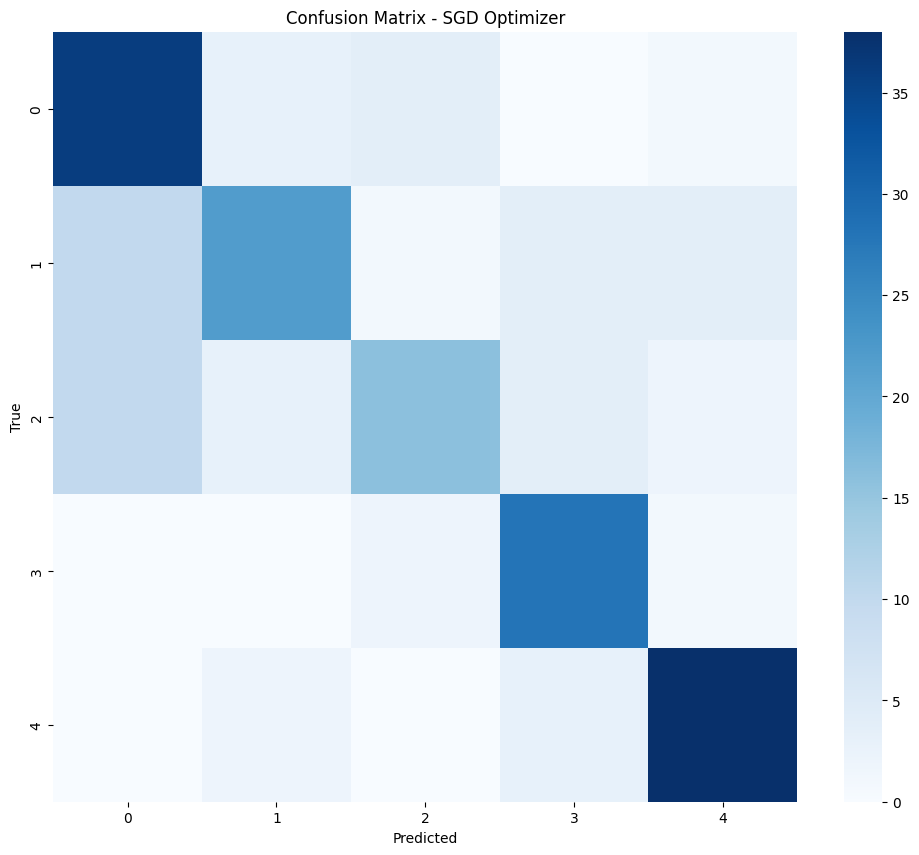

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step


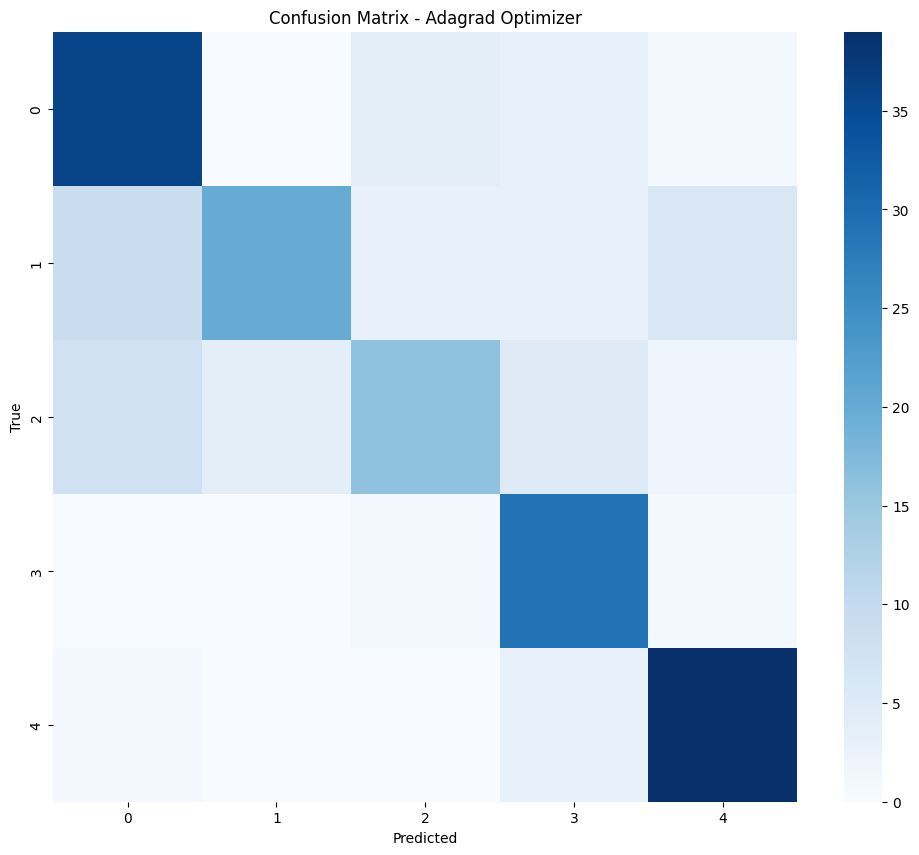

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# ============================
# 1) Compute Test Accuracies
# ============================

test_acc = {}

# Adam
loss_a, acc_a = model_adam.evaluate(x_test, y_test, verbose=0)
test_acc["Adam"] = acc_a

# SGD
loss_s, acc_s = model_sgd.evaluate(x_test, y_test, verbose=0)
test_acc["SGD"] = acc_s

# Adagrad
loss_g, acc_g = model_ada.evaluate(x_test, y_test, verbose=0)
test_acc["Adagrad"] = acc_g


# ============================
# 2) Print Comparison Table
# ============================

print("\n====== OPTIMIZER COMPARISON TABLE ======")
df_results = pd.DataFrame({
    "Optimizer": ["Adam", "SGD", "Adagrad"],
    "Train Time (s)": [times["Adam"], times["SGD"], times["Adagrad"]],
    "Test Accuracy": [test_acc["Adam"], test_acc["SGD"], test_acc["Adagrad"]],
})
print(df_results)


# ============================
# 3) Accuracy Bar Chart
# ============================

plt.figure(figsize=(8,5))
plt.bar(test_acc.keys(), test_acc.values())
plt.title("Optimizer Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Optimizer")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# ============================
# 4) Confusion Matrices
# ============================

def plot_cm(model, y_true, title):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Adam Confusion Matrix
plot_cm(model_adam, y_test, "Confusion Matrix - Adam Optimizer")

# SGD Confusion Matrix
plot_cm(model_sgd, y_test, "Confusion Matrix - SGD Optimizer")

# Adagrad Confusion Matrix
plot_cm(model_ada, y_test, "Confusion Matrix - Adagrad Optimizer")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

optimizers = {
    "Adam": model_adam,
    "SGD": model_sgd,
    "Adagrad": model_ada
}

# Class names (must match your label indices)
class_names = Selected_classes     # Example: ["angry","disgust","fear","happy","neutral","sad","surprise"]

# y_test is already integer labels (NO one-hot)
y_true = y_test   # <-- Correct!

for opt_name, model in optimizers.items():
    print("="*70)
    print(f"           Classification Report for {opt_name} Optimizer")
    print("="*70)

    # Predict
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print report
    print(classification_report(
        y_true,
        y_pred_classes,
        target_names=class_names
    ))

    print("\n\n")


           Classification Report for Adam Optimizer
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step
                precision    recall  f1-score   support

ApplyEyeMakeup       0.77      0.77      0.77        44
       Archery       0.80      0.59      0.68        41
  BabyCrawling       0.69      0.57      0.62        35
   BalanceBeam       0.80      0.90      0.85        31
  BandMarching       0.71      0.93      0.81        43

      accuracy                           0.75       194
     macro avg       0.76      0.75      0.75       194
  weighted avg       0.75      0.75      0.75       194




           Classification Report for SGD Optimizer
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step
                precision    recall  f1-score   support

ApplyEyeMakeup       0.64      0.82      0.72        44
       Archery       0.73      0.54      0.62        41
  BabyCrawling       0.70      0.46      0.55        35
   BalanceBeam       0.72      0.90      0.80        31
  BandMarching       0.83   

In [ ]:
# Save the trained model Adam_optimizer
model_adam.save('Action_Recognition_model_Adam_optimizer.keras')
print("Model saved to Action Recognition_model_Adam_optimizer.keras")

# Save the trained model SGD_optimizer
model_sgd.save('Action_Recognition_model_SGD_optimizer.keras')
print("Model saved to Action Recognition_model_SGD_optimizer.keras")

# Save the trained model Adagrad_optimizer
model_ada.save('Action_Recognition_model_Adagrad_optimizer.keras')
print("Model saved to Action Recognition_model_Adagrad_optimizer.keras")

Model saved to Action Recognition_model_Adam_optimizer.keras
Model saved to Action Recognition_model_SGD_optimizer.keras
Model saved to Action Recognition_model_Adagrad_optimizer.keras
